# SARSA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# display output
from random import uniform
import random
import time
from IPython.display import display, clear_output

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

## SARSA

In [4]:
# create a grid object
grid = Gridworld(5)

In [5]:
# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

# initialize other parameters
gamma = 0.99
lr = 0.9

In [6]:
def choose_action(state, epsilon):
    
    # choose an action type: explore or exploit
    action_type = int(np.random.choice(2, 1, p=[epsilon,1-epsilon]))

    # find best action based on Q values
    best_action_index = np.argmax(Q_values[state])

    # pick a random action
    random_action_index = random.choice(range(4))

    # while random action is the same as the best action, pick a new action
    while random_action_index == best_action_index:
        random_action_index = random.choice(range(4))

    # choose an action based on exploit or explore
    if action_type == 0:
        # explore
        # print("explore")
        action_index = random_action_index
    else:
        # exploit
        # print("exploit")
        action_index = best_action_index
        
    return action_index

In [7]:
# # randomly generate Q values (for testing purpose)
# Q_values = np.random.randint(10, size=(state_count, action_count))
# Q_values

In [8]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

In [9]:
epsilon = 0.1
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []

# iterate over 500 episodes
for episode in range(500):
    
    reward_list = []
    
    delta = 0
    
    # initialize state (output: [4, 4])
    state_vector = grid.initial_state()
    state_index = grid.states.index(state_vector)

    # choose an action based on epsilon-greedy (output: action index ie. 0)
    action_index = choose_action(state_index, epsilon)
    action_vector = actions[action_index]

    # iterate over 200 steps within each episode
    for step in range(200):

        # get the next state and reward after taking the chosen action in the current state
        next_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        next_state_index = grid.states.index(list(next_state_vector))
        
        # add reward to list
        reward_list.append(reward)
        
        # choose an action based on epsilon-greedy (output: action index ie. 0)
        next_action_index = choose_action(next_state_index, epsilon)
        next_action_vector = actions[next_action_index]

        # calculate max delta change for plotting max q value change
        Q_value = Q_values[state_index][action_index] + lr*(reward + gamma*Q_values[next_state_index][next_action_index] - Q_values[state_index][action_index])
        delta = max(delta, np.abs(Q_value - Q_values[state_index][action_index]))   
        
        # update Q value
        Q_values[state_index][action_index] = Q_values[state_index][action_index] + lr*(reward + gamma*Q_values[next_state_index][next_action_index] - Q_values[state_index][action_index])
        
        # update state and action vector
        state_vector = list(next_state_vector)
        state_index = grid.states.index(state_vector)
        action_vector = list(next_action_vector)
        action_index = next_action_index
    
    delta_list.append(delta)
    
    average_reward_list.append(Average(reward_list))
    
    # cumulative rewards
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)

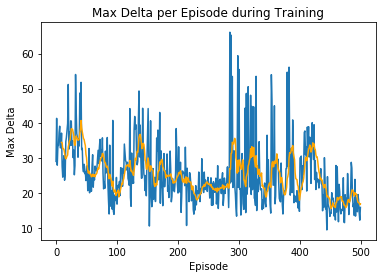

In [10]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

# plot moving average
delta_frame = pd.DataFrame(delta_list)
rolling_mean = delta_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

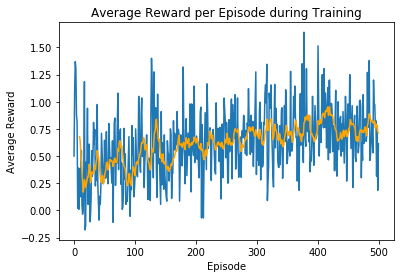

In [11]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# plot moving average
reward_frame = pd.DataFrame(average_reward_list)
rolling_mean = reward_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

Text(0, 0.5, 'Cumulative Reward')

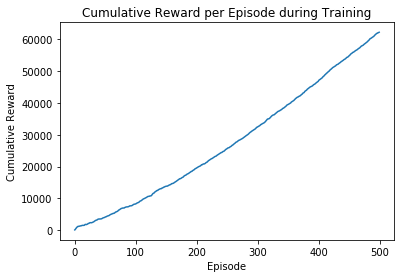

In [12]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [13]:
np.set_printoptions(precision=2)
Q_values

array([[82.26, 83.84, 77.83, 92.24],
       [82.33, 88.39, 82.98, 79.24],
       [79.98, 81.08, 81.64, 83.79],
       [75.58, 76.43, 83.83, 75.9 ],
       [-1.  , -0.99, 76.67,  0.  ],
       [78.88, 86.4 , 79.71, 79.45],
       [90.81, 80.48, 81.37, 79.93],
       [91.94, 76.55, 76.48, 82.36],
       [77.14, 77.04, 76.76, 76.9 ],
       [62.29, 68.36, 81.66, 67.61],
       [73.61, 74.19, 76.31, 73.39],
       [76.1 , 83.02, 75.57, 75.31],
       [76.12, 75.71, 74.82, 75.5 ],
       [71.53, 75.93, 74.  , 75.81],
       [68.38, 71.06, 74.75, 76.15],
       [71.63, 72.18, 70.6 , 71.43],
       [76.78, 72.77, 71.11, 72.18],
       [71.63, 69.64, 70.57, 79.43],
       [80.5 , 70.33, 68.94, 72.52],
       [59.25, 69.04, 70.02, 79.99],
       [71.09, 79.54, 69.6 , 71.37],
       [79.25, 74.51, 73.3 , 73.43],
       [78.49, 71.71, 68.26, 74.32],
       [68.21, 69.15, 70.52, 73.55],
       [74.88, 68.75, 68.53, 73.51]])

# Visualize 

In [14]:
# PRINT POLICY TABLE ################################################################################
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(Q_values)):
    
    # find the best action at each state
    best_action = np.argmax(Q_values[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
       0      1     2      3     4
0   left  right  left   down  down
1  right     up    up     up  down
2   down  right    up  right  left
3  right     up  left     up  left
4  right     up    up   left    up



## Extract Policy

In [15]:
# initialize q values for all state action pairs
policy = np.zeros((state_count, action_count))

In [16]:
for state in range(len(Q_values)):
    
    # find the best action at each state
    best_action = np.argmax(Q_values[state])
    
    policy[state][best_action] = 1

In [17]:
policy

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

## Testing 

In [18]:
def generate_episode(steps):

    # set initial state
    state_vector = grid.initial_state()

    # initialize state (with iniitial state), action list and reward list
    state_list = [state_vector]
    action_list = []
    reward_list = []

    # generate an episode
    for i in range(steps):

        # pick an action based on categorical distribution in policy
        action_index = int(np.random.choice(action_count, 1, p=policy[grid.states.index(state_vector)])) 
        action_vector = actions[action_index] # convert the integer index (ie. 0) to action (ie. [-1, 0])

        # get new state and reward after taking action from current state
        new_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        state_vector = list(new_state_vector)

        # save state, action chosen and reward to list
        state_list.append(state_vector)
        action_list.append(action_vector)
        reward_list.append(reward)
        
    return state_list, action_list, reward_list

In [19]:
avg_test_reward_list = []

# using the trained policy, generate 20 episodes
for test in range(20):
    
    # generate an episode of specified step count
    state_list, action_list, reward_list = generate_episode(200)
    
    avg_test_reward_list.append(Average(reward_list))

Text(0, 0.5, 'Average Reward')

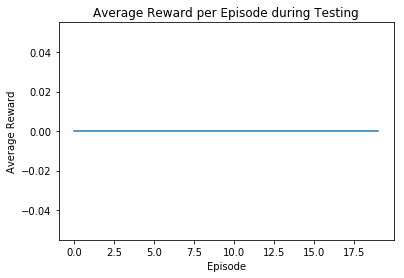

In [20]:
# average reward per episode
plt.plot(avg_test_reward_list)
plt.title('Average Reward per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Average Reward')